*Copyright (C) 2024 Jannik Luboeinski*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

---

# ATRLIF neuron in different implementations
_A Leaky Integrate-and-Fire neuron with adaptive threshold and adaptive refractoriness._

### Imports

In [1]:
# Import general modules
import numpy as np
import matplotlib.pyplot as plt
import os

# Import Lava core modules
from lava.magma.core.run_configs import Loihi2SimCfg, Loihi2HwCfg
from lava.magma.core.run_conditions import RunSteps

# Import Lava monitors
from lava.proc.monitor.process import Monitor

# Import ATRLIF process
from lava.proc.atrlif.process import *

### Simulation test function

In [2]:
def simulation_test(run_config, label, bias_mant=3, bias_exp=0, **kwargs):
    '''
    Function to simulate and monitor a population of ATRLIF neurons.
    
    Parameters
    ----------
    run_config : `AbstractLoihiSimRunCfg`
        Run configuratrion object for Lava.
    label : `str`
        Label for the current simulation.
    bias_mant : `float`, optional
        Mantissa part of neuron's bias. Equals `bias` for floating-point implementation.
    bias_exp : `int`, optional
        Exponent part of neuron's bias, if needed. Ignored in floating-point implementation.
    **kwargs : `dict`
        Additional keyword arguments (cf. 'atrlif_process.py').
    '''

    # Initialization
    n_neurons = 1 # the number of neurons
    num_steps = 20 # the number of timesteps
    output_period = 1 # the sampling period (in timesteps)
    num_samples = num_steps // output_period + 1 # the number of samples
    atrlif = ATRLIF(shape=(n_neurons,), bias_mant=bias_mant, bias_exp=bias_exp, **kwargs)
    
    # Set monitors for the different variables
    voltage_mon = Monitor()
    voltage_mon.probe(atrlif.v, num_samples)
    refractory_mon = Monitor()
    refractory_mon.probe(atrlif.r, num_samples)
    threshold_mon = Monitor()
    threshold_mon.probe(atrlif.theta, num_samples)
    spike_mon = Monitor()
    spike_mon.probe(atrlif.s_out, num_samples)
    
    # Run the simulation
    atrlif.run(condition=RunSteps(num_steps=num_samples, blocking=True), run_cfg=run_config)
    
    # Retrieve process name
    process_name = atrlif.v.process.name
    
    # Collect samples
    data_v = voltage_mon.get_data()[process_name]['v']
    data_r = refractory_mon.get_data()[process_name]['r']
    data_theta = threshold_mon.get_data()[process_name]['theta']
    data_s = spike_mon.get_data()[process_name]['s_out']
    
    # Stop the simulation
    atrlif.stop()
    
    # Normalize data from fixed-point implementation (right shifting by `bias_exp`)
    if bias_exp > 0:
        data_v = data_v * 2**(-bias_exp)
        data_r = data_r * 2**(-bias_exp)
        data_theta = data_theta * 2**(-bias_exp)
        
    # Save voltage and spike data
    header = "t"
    for var in ["v", "r", "theta", "s"]:
        for n in range(n_neurons):
            header += f"\t{var}_{n}"
    times = np.arange(0, len(data_v))
    os.makedirs("./results", exist_ok=True)
    np.savetxt(f"./results/atrlif_v_{label}.txt",
               np.column_stack([times, data_v, data_r, data_theta, data_s]), 
               fmt="%.0f"+n_neurons*"\t%.4f\t%.4f\t%.4f"+n_neurons*"\t%.0f", 
               header=header)

### Plotting function

In [3]:
def plot(data_stacked_1, data_stacked_2, framework_name_1, framework_name_2, X_cols, store_path = "figure.svg"):
    '''
    Function to plot the results from two different paradigms.
    Based on https://github.com/jlubo/memory-consolidation-stc/blob/main/analysis/plotSimResultsComparisonMeanSEM.py.
    
    Parameters
    ----------
    data_stacked_1 : `numpy.ndarray`
        Data array of first paradigm. First column contains the time, the other columns contain the data specified via `X_cols`.
    data_stacked_2 : `numpy.ndarray`
        Data array of second paradigm. First column contains the time, the other columns contain the data specified via `X_cols`.
    framework_name_1 : `str`
        Name of the first framework/paradigm.
    framework_name_2 : `str`
        Name of the second framework/paradigm.
    X_cols : `dict` of `int`
        Dictionary specifying the data columns to be plotted.
    store_path : `str`, optional
        Path to store the resulting graphics file.
    '''
    
    # Figure setting
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8, 8), height_ratios=[1.0, 0.4])
    
    # Plot membrane voltage, effective voltage, and threshold dynamics
    axes[0].set_ylabel(f"Membrane dynamics (mV)")
    axes[0].plot(data_stacked_1[:,0], data_stacked_1[:,X_cols["theta"]], color="#aaeeaa", label=f"Threshold {framework_name_1}", marker='None', zorder=9)
    axes[0].plot(data_stacked_2[:,0], data_stacked_2[:,X_cols["theta"]], color="#556655", linestyle='dotted', label=f"Threshold {framework_name_2}", marker='None', zorder=10)
    axes[0].legend()
    axes[0].plot(data_stacked_1[:,0], (data_stacked_1[:,X_cols["voltage"]]-data_stacked_1[:,X_cols["ref"]]), color="#ff0000", label=f"Effective voltage {framework_name_1}", marker='None', zorder=9)
    axes[0].plot(data_stacked_2[:,0], (data_stacked_2[:,X_cols["voltage"]]-data_stacked_2[:,X_cols["ref"]]), color="#330000", linestyle='dashed', label=f"Effective voltage {framework_name_2}", marker='None', zorder=10)
    axes[0].legend()
    # Set x-ticks (to integer values only)
    axes[0].set_xticks(np.arange(min(data_stacked_1[:,0]), np.ceil(max(data_stacked_1[:,0])) + 1, step=2))
    axes[0].set_xticks(np.arange(min(data_stacked_1[:,0]), np.ceil(max(data_stacked_1[:,0])) + 1, step=1), minor=True)

    # Plot spikes
    axes[1].set_xlabel("Time (steps)")
    axes[1].set_ylabel(f"Spikes")
    # Get logical masks
    mask_1 = data_stacked_1[:,X_cols["spike"]] > 0.5
    mask_2 = data_stacked_2[:,X_cols["spike"]] > 0.5
    axes[1].plot(data_stacked_1[:,0][mask_1], data_stacked_1[:,X_cols["spike"]][mask_1], color="#ff0000", marker='o', 
                 linestyle='none', label=framework_name_1, zorder=9)
    axes[1].plot(data_stacked_2[:,0][mask_2], data_stacked_2[:,X_cols["spike"]][mask_2], color="#330000", marker='o', markerfacecolor='none', 
                 linestyle='none', label=framework_name_2, zorder=10)
    axes[1].tick_params(left = False, labelleft = False)
    axes[1].legend()

    # Save figure as vector graphics
    fig.savefig(store_path)

### Running the simulations

In [4]:
# Simulate with default values in floating- and fixed-point implementation
simulation_test(Loihi2SimCfg(select_tag="floating_pt"),
                "cpu-float")
simulation_test(Loihi2SimCfg(select_tag="fixed_pt"),
                "cpu-fixed",
                bias_exp=6)

# Simulate with constant threshold dynamics in floating- and fixed-point implementation
simulation_test(Loihi2SimCfg(select_tag="floating_pt"),
                "cpu-float_theta_const",
                delta_theta=0,
                theta_step=0)
simulation_test(Loihi2SimCfg(select_tag="fixed_pt"),
                "cpu-fixed_theta_const",
                delta_theta=0,
                theta_step=0,
                bias_exp=6)

PyATRLIFModelFloat initialized
PyATRLIFModelFixed initialized
PyATRLIFModelFloat initialized
PyATRLIFModelFixed initialized


### Plotting the results from default setting
_The membrane voltage minus the value of the refractory state yields the effective voltage, which is compared against the threshold value to determine spiking._

_The dynamics of the threshold hampers spiking if the last spike occurred not too long ago._

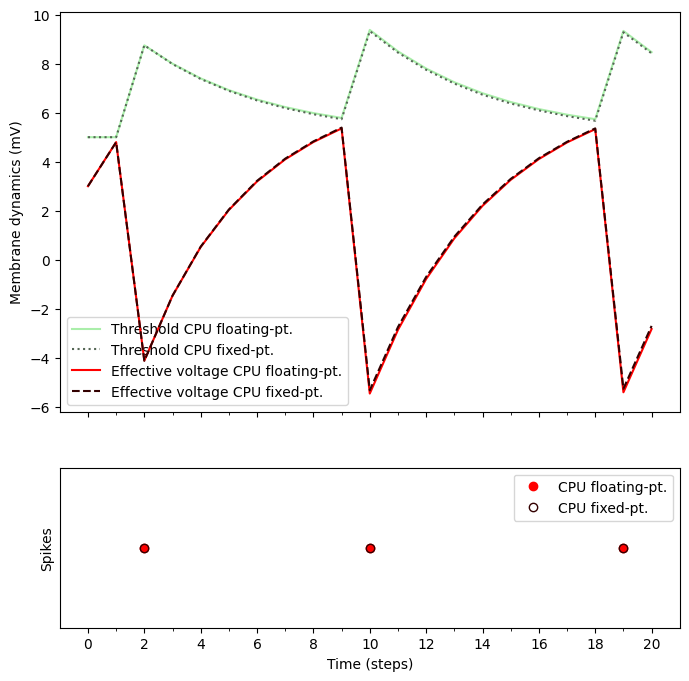

In [5]:
data_stacked_cpu_float = np.loadtxt(f'./results/atrlif_v_cpu-float.txt')
data_stacked_cpu_fixed = np.loadtxt(f'./results/atrlif_v_cpu-fixed.txt')

plot(data_stacked_cpu_float, data_stacked_cpu_fixed, "CPU floating-pt.", "CPU fixed-pt.", 
     {"voltage": 1, "ref": 2, "theta": 3, "spike": 4},
     store_path = f"./results/atrlif_cpu-float_cpu-fixed.svg")

### Plotting the results from constant threshold setting
_The membrane voltage minus the value of the refractory state yields the effective voltage, which is compared against the threshold value to determine spiking._

_Here, the threshold value remains constant, which essentially yields the dynamics of a standard LIF neuron (with refractoriness)._

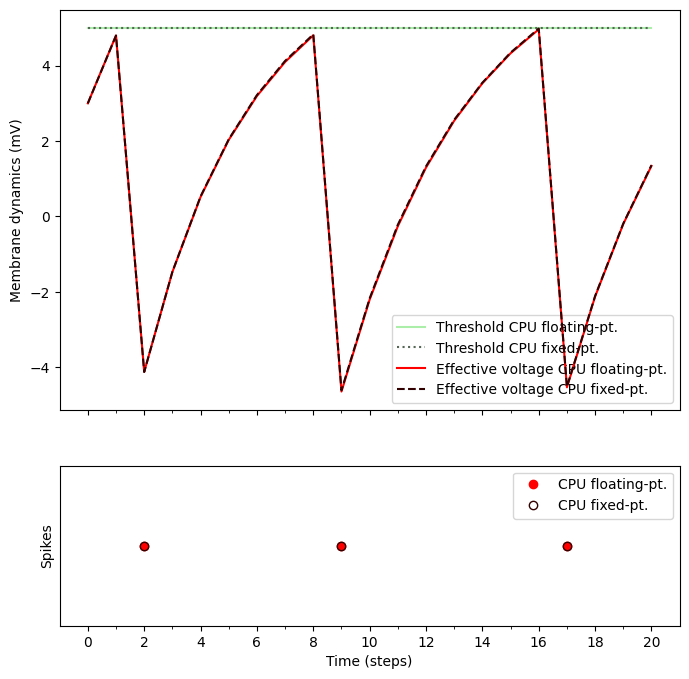

In [6]:
data_stacked_cpu_float = np.loadtxt(f'./results/atrlif_v_cpu-float_theta_const.txt')
data_stacked_cpu_fixed = np.loadtxt(f'./results/atrlif_v_cpu-fixed_theta_const.txt')

plot(data_stacked_cpu_float, data_stacked_cpu_fixed, "CPU floating-pt.", "CPU fixed-pt.", 
     {"voltage": 1, "ref": 2, "theta": 3, "spike": 4},
     store_path = f"./results/atrlif_theta_const_cpu-float_cpu-fixed.svg")